The curve below is part of a family of $C^2$, nonself-intersecting curves whose limit is surjective on the equilateral triangle. 

In [1]:
import os
import sys
import functools as ft

current_dir = os.getcwd()
parent_dir = os.path.abspath(os.path.join(current_dir, ".."))
sys.path.append(parent_dir)

import puncturedfem as pf

import numpy as np
import matplotlib.pyplot as plt
import scipy.interpolate as interpolate

#accepts the vertices of a triangle to find the coordinates of a space filling curve
def SFC(A,B,C,n,p):
    #switch on the top 2 bits of n. 
    if p==0:
        return [2*A/3+(A+B+C)/9,2*(A/6+2*B/3+C/6)/3+(A+B+C)/9,2*C/3+(A+B+C)/9]
    match n>>2*(p-1) & 3:
        case 0:
            return SFC(A,(A+C)/2,(A+B)/2,n,p-1)
        case 1:
            return SFC((A+B)/2,B,(C+B)/2,n,p-1)
        case 2:
            return SFC((B+C)/2,(A+B)/2,(A+C)/2,n,p-1)
        case 3:
            return SFC((A+C)/2,(B+C)/2,C,n,p-1)
        
family_param=2
idxs=np.arange(3*4**family_param)
A=np.array([0,0])
B=np.array([1.0/2,np.sqrt(3)/2])
C=np.array([1,0])
D=(A+B+C)/3
A_=(1-1/4**family_param)*A+1/4**family_param*D
B_=(1-1/4**family_param)*B+1/4**family_param*D
C_=(1-1/4**family_param)*C+1/4**family_param*D
def myfun_x(n):
    return SFC(A_,B_,C_,n//3,family_param)[n%3][0]
def myfun_y(n):
    return SFC(A_,B_,C_,n//3,family_param)[n%3][1]
xs = np.append([0,A_[0]],np.append(np.array([myfun_x(n) for n in idxs]),[C_[0],1]))
ys = np.append([0,0],np.append(np.array([myfun_y(n) for n in idxs]),[0,0]))

#tck,u= interpolate.splprep([xs,ys],s=0)

## Construct the mesh cell


In [2]:
vA=pf.Vert(0,0,0)
vB=pf.Vert(1/2,np.sqrt(3)/2,1)
vC=pf.Vert(1,0,2)
badedge=pf.Edge(vA,vC,curve_type="spline", pos_cell_idx=0, pts=[xs,ys])
def Bd(edge,n,l,r):
    if n<=0:
        return [edge]
    e0,e1 = pf.split_edge(e=edge, t_split=(l+r)/2)
    return Bd(e0,n-1,l,(l+r)/2)+Bd(e1,n-1,(l+r)/2,r)
edges = Bd(badedge,2*(family_param-1),0,2*np.pi) + [
    pf.Edge(vC,vB,pos_cell_idx=0,idx=1),
    pf.Edge(vB,vA,pos_cell_idx=0,idx=2)
]
#Todo: this is a hack, since edges are responsible for defining their indices, splitting edges has no
#way to know which indices are available.
for i,e in enumerate(edges):
    e.idx=i


With the edges defined, let's make the mesh cell $K$.

In [3]:
K = pf.MeshCell(idx=0, edges=edges)

Let's parameterize the edges, and plot the edges to check that we have what we 
want. These curves are a little too close to the boundary, and we can fix that easily, but we'll ignore it for the moment

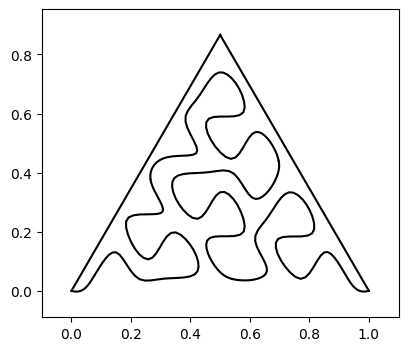

In [4]:
quad_dict = pf.get_quad_dict(n=64,p=7)
K.parameterize(quad_dict)
pf.plot.MeshPlot(K.get_edges()).draw()

Since we have subdivided the bad edge, we must build our *bad* basis functions for $V_p^{\partial K}$ by hand. 

Setting up Nyström Solver... 768 sampled points on 6 Edges


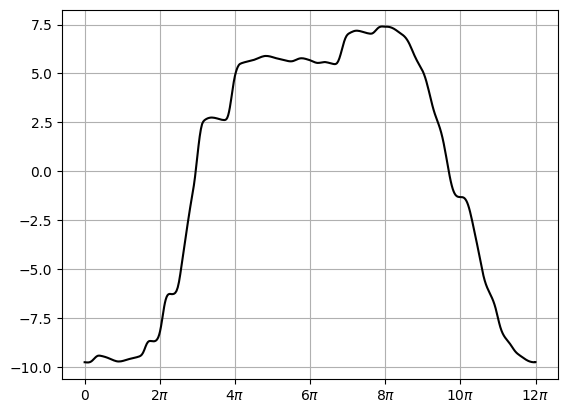

10.476736399421522


In [5]:
x1, x2 = K.get_boundary_points()
# The trace functions here will be much easier to define in barycentric coordinates
ones = np.ones(shape=x1.shape)
rhv = np.stack([ones,x1,x2])
M = np.transpose(np.stack([np.append([1],A),np.append([1],B),np.append([1],C)]))
M_=np.linalg.inv(M)
barycentric = np.matmul(M_,rhv)
phi1_trace = barycentric[0]
phi2_trace = barycentric[1]
phi3_trace = barycentric[2]
# print(np.transpose(barycentric))
def silly (a,b,c):
    if min(abs(a),abs(c))<1e-15:
        if abs(b)>1e-10:
            return min(abs(a),abs(c)) 
    return b
phi4_trace = [silly(a,b,c) for a,b,c in np.transpose(barycentric)]
# print(np.transpose(phi4_trace))
#what a terrible way to define this function
nyst = pf.NystromSolver(K,verbose=True)
phi4 = pf.LocalFunction(nyst=nyst,has_poly_trace=False)
phi4.set_trace_values(phi4_trace)
phi4.compute_polynomial_part()
phi4.compute_polynomial_part_trace()
phi4.compute_harmonic_conjugate()
pf.plot.TracePlot(
    traces=[phi4.get_harmonic_conjugate()],
    K=K,
    title="",
    quad_dict=quad_dict,
).draw()
phi4.compute_harmonic_weighted_normal_derivative()
print(phi4.get_h1_semi_inner_prod(phi4))


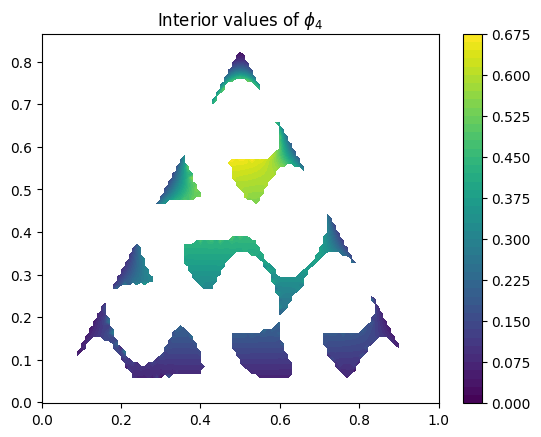

In [6]:
phi4.compute_interior_values()

phi4_computed = phi4.int_vals
v_x1_computed = phi4.int_grad1
v_x2_computed = phi4.int_grad2

plt.figure()
plt.contourf(K.int_x1, K.int_x2, phi4_computed, levels=50)
plt.colorbar()
plt.title("Interior values of $\phi_4$")
plt.show()